In [27]:
!pip install --upgrade "jax[cpu]" fancy-einsum

  Using cached fancy_einsum-0.0.3-py3-none-any.whl (6.2 kB)


In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap, random
from matplotlib import pyplot as plt
from fancy_einsum import einsum

In [2]:
# Data model
# Regression generated from Gaussian linear

def gen_theta(d: int, key: random.PRNGKey) -> jnp.ndarray:
    return random.normal(key, shape=(d,))

def gen_data(d: int, variances: jnp.ndarray, n: int, error: float, theta: jnp.ndarray, key: random.PRNGKey, scaled=False) -> jnp.ndarray:
    key_x, key_y = random.split(key)

    x = random.multivariate_normal(key_x, shape=(n,), mean=jnp.zeros(d), cov=jnp.diag(variances))
    y = x @ theta + (random.normal(key_y, shape=(n,)) * jnp.sqrt(error))

    if scaled:
        x = x / jnp.sqrt(n)
        y = y / jnp.sqrt(n)

    return x, y

In [4]:
keys = random.split(random.PRNGKey(0), num=10)

N_DIM = 2
N=10
theta_true = gen_theta(d=N_DIM, key=keys[0])
variances = random.exponential(keys[1], shape=(N_DIM,))
error = 1.
x, y = gen_data(d=N_DIM, variances=variances, n=10, error=error, theta=theta_true, key=keys[2])

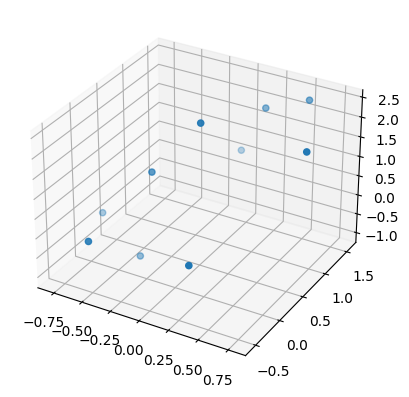

In [5]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:, 0], x[:, 1], y)
plt.show()

In [6]:
def risk(theta_true: jnp.ndarray, theta: jnp.ndarray, error: float, variances: jnp.ndarray) -> jnp.ndarray:
    return error + variances @ ((theta_true - theta) ** 2)

def empirical_risk(x: jnp.ndarray, y: jnp.ndarray, theta: jnp.ndarray) -> jnp.ndarray:
    return jnp.mean((y - x @ theta) ** 2)

def train_theta(theta_init: jnp.ndarray, x: jnp.ndarray, y: jnp.ndarray, lr: float | jnp.ndarray, n_epochs: int) -> jnp.ndarray:
    theta = theta_init
    thetas = [theta]
                    
    d = theta.shape[0]

    if isinstance(lr, float):
        lr = jnp.diag(jnp.ones(d) * lr)
    elif lr.shape != (d, d):
        lr = jnp.diag(lr)

    empirical_risk_ = jit(lambda theta: empirical_risk(x, y, theta))

    for i in range(n_epochs):
        theta = theta - lr @ grad(empirical_risk_)(theta)
        thetas.append(theta)

    return jnp.array(thetas)

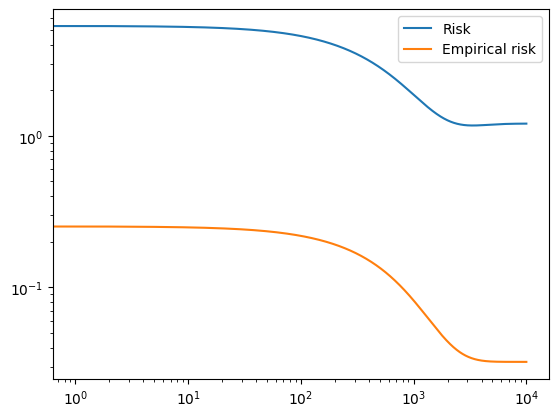

theta_true: [0.75 5.  ]
theta: [0.3274933 5.4104505]


In [13]:
def figure_2a():
    theta_true = jnp.array([1.5, 10]) * .5
    variances = jnp.array([1., 0.15])
    lr = jnp.array([0.05, 0.05])

    x, y = gen_data(d=2, variances=variances, n=20, error=1., theta=theta_true, key=keys[3], scaled=True)

    theta_init = jnp.array([0., 0.])
    thetas = train_theta(theta_init=theta_init, x=x, y=y, lr=lr, n_epochs=10_000)

    risks = vmap(lambda theta: risk(theta_true, theta, error=1., variances=variances))(thetas)
    empirical_risks = vmap(lambda theta: empirical_risk(x, y, theta))(thetas)

    plt.plot(risks, label='Risk')
    plt.plot(empirical_risks, label='Empirical risk')

    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

    print(f"theta_true: {theta_true}")
    print(f"theta: {thetas[-1]}")

figure_2a()

In [ ]:
def figure_2b():
    theta_true = jnp.array([1.5, 10])
    variances = jnp.array([1., 0.15])
    lr = jnp.array([0.05, 0.05])

    x, y = gen_data(d=2, variances=variances, n=100, error=1., theta=theta_true, key=keys[3])

    theta_init = jnp.array([0., 0.])
    thetas = train_theta(theta_init=theta_init, x=x, y=y, variances=variances, error=1., lr=lr, n_epochs=10_000)

    risks = vmap(lambda theta: risk(theta_true, theta, error=1., variances=variances))(thetas)

    plt.plot(risks)
    plt.xscale('log')
    plt.show()

    print(f"theta_true: {theta_true}")
    print(f"theta: {thetas[-1]}")

figure_2b()